<a href="https://colab.research.google.com/github/VidushiBhatia/Mining-Opinions-using-Transformers-PyTorch/blob/main/Mining_Opinions_to_Predict_Customer_Trends_using_Transformers_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Mining Opinions to Predict Customer Trends*** <br> *(Transfer Learning and Fine Tuning of Transformers in PyTorch)*



---



### Overview

* **Objective**: Observe trends in change of opinions / interest of customers for different product types across time. At brand level, can also be used for brand value monitoring and competitor analysis.

* **Dataset used**: 'Unprocessed' tar file from [Multi-Domain Sentiment Dataset (version 2.0)](https://www.cs.jhu.edu/~mdredze/datasets/sentiment/)

### 1 - Packages

In [1]:
# # # Install for using ignite
!pip install torch==1.8.1 pytorch-transformers pytorch-ignite

     |████████████████████████████████| 804.1 MB 923 bytes/s 
     |████████████████████████████████| 176 kB 54.2 MB/s 
     |████████████████████████████████| 240 kB 53.1 MB/s 
     |████████████████████████████████| 895 kB 52.5 MB/s 
     |████████████████████████████████| 1.2 MB 56.8 MB/s 
     |████████████████████████████████| 131 kB 60.1 MB/s 
     |████████████████████████████████| 79 kB 6.6 MB/s 
     |████████████████████████████████| 8.1 MB 14.1 MB/s 
     |████████████████████████████████| 138 kB 56.7 MB/s 
     |████████████████████████████████| 127 kB 61.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages tha

In [2]:
import os                                       
import tarfile                                  
from bs4 import BeautifulSoup                   
import pandas as pd                             
import regex as re                              
import string                                   
import numpy as np  
from collections import namedtuple
from typing import Tuple


# Relevant torch packages for transfer learning and fine tuning 
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
from pytorch_transformers import BertTokenizer
from pytorch_transformers.optimization import AdamW
import torch.nn as nn
import torch.nn.functional as F
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage, Accuracy 
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import CosineAnnealingScheduler, PiecewiseLinear, create_lr_scheduler_with_warmup, ProgressBar
from pytorch_transformers import cached_path

# Other packages for parallel processing
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count

from tqdm.notebook import tqdm
from itertools import repeat                    

# interactive dashboard
import ipywidgets
from IPython.display import display, clear_output
from ipywidgets import Layout
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# Check if GPU is running
!nvidia-smi

Tue Nov 16 03:11:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 2 - Load XML to a Dataframe

The dataset used for this notebook has multiple positive and negative review files compressed into a tar format. To get a dataframe with x and y values (text and sentiment labels respectively), we need to execute the following:
1. Extract relevant files from tar
2. Covert XML tree into a dataframe for relevant elements
3. Create a train and test set with processed x and y values


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Helper Function 1: Extract XML data from tar files
def ExtractContent(path):
  tar = tarfile.open(path,'r' )
  
  # Find relevant file names
  files = [name for name in tar.getnames()]
  pos_files = []
  neg_files = []
  for file in files:
    if file.endswith('positive.review'): 
      pos_files.append(file)
    if file.endswith('negative.review'):
      neg_files.append(file)

  # Extract Positive and Negative reviews
  pos_content = []
  for file in pos_files:
    extracted_file = tar.extractfile(file)
    content = extracted_file.read()
    pos_content.append(content)

  neg_content = []
  for file in neg_files:
    extracted_file = tar.extractfile(file)
    content = extracted_file.read()
    neg_content.append(content)
  return pos_content, neg_content

In [6]:
# Helper Function 2: Create a dataframe from XML file
def CreateDF(content_list):
  # Check the exhaustive list of elements with soup.find_all() and create a dataframe with only relevant columns
  # columns = ['unique_id','asin','product_name','product_type','helpful','rating','title','date','reviewer','reviewer_location','review_text']

  columns = ['product_type','rating','date','title','review_text']     # only processing relevant columns
  interim_df = []
  for idx, item in enumerate(content_list):      # iterate over positive and negative file-list
    for content in item:                         # iterate over all extracted files
      bs_content = BeautifulSoup(content, 'lxml')
      table_rows = bs_content.find_all("review") # create rows from the root element
      df = pd.DataFrame()
      for c in columns:                          # add corresponding columns to the created dataframe
        values = bs_content.find_all(c)
        if len(values)!=len(table_rows):         # in case the size of each element is not equal
          col = []
          for t in table_rows:
            row_val = t.find_all(c)
            row = [t.text.strip() for t in row_val]
            col.append(row[0])
        else:
          col = [t.text.strip() for t in values]
        df[c] = col
      interim_df.append(df)
  output = pd.concat(interim_df)                # create a master df with all positive, negative reviews
  return output

In [7]:
# LOAD DATA USING HELPER FUNCTIONS

# STEP 1 - Extract relevant content from tar file
path = '/content/drive/My Drive/NLP - Sentiment Analysis & Keyword Extraction/unprocessed.tar.gz'
pos_content, neg_content = ExtractContent(path)

# STEP 2 - Convert relevant elements of XML to dataframe 
content_list = [pos_content, neg_content]
master_df = CreateDF(content_list)

# STEP 3 - Some formatting
master_df['label'] = (pd.to_numeric(master_df['rating'])>3)*1  # ratings >3 are labeled as positive sentiment
master_df['text'] =  master_df['title'].str.cat(master_df['review_text'], sep=' ', na_rep='?') 
master_df['text'] = master_df['text'].replace(r" +"," ",regex = True) # remove whitespaces

In [8]:
# Create train and test datasets

temp_mask1 = np.random.rand(len(master_df)) < 0.9  # 10% sample to be used in the interative dashboard 
temp_set1 = master_df[temp_mask1]
sample = master_df[~temp_mask1].reset_index()

temp_mask2 = np.random.rand(len(temp_set1)) < 0.7  # 70% data is train set
train_set  = temp_set1[temp_mask2].reset_index()
test_set  = temp_set1[~temp_mask2].reset_index()
train_set = train_set.drop(['rating','title','review_text','product_type','date'], axis='columns') # retain only processed columns
test_set = test_set.drop(['rating','title','review_text','product_type','date'], axis='columns')
 
print("len of master df: ", len(master_df), "\nlen of train set: ",len(train_set), "\nlen of test set: ",len(test_set), "\nlen of sample: ",len(sample))

print("sum: ", len(train_set)+len(test_set)+len(sample))

len of master df:  38548 
len of train set:  24246 
len of test set:  10451 
len of sample:  3851
sum:  38548


### 3 - Tokenize Representations

The neural network model would require word representations to read the text. To execute this, we will define a text processing module which will take "text" as input and return "sequences of integers".

To convert text to this "id", there are multiple vocabularies available. In this notebook, we'll use `pytorch-transformers’s BertTokenizer` for tokenization.

In [9]:
# import the 'bert-base-cased' tokenizer from PyTorch
from pytorch_transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


# Initialize key metrics for tokenizer
num_max_positions = 256                 # set max positions allowed in tokenizer
CLS = '[CLS]'                           # Special token for sentence classification
PAD = '[PAD]'                           # Special token for padding


# set the configurations for fine tuning pre-trained model to the considered dataset (incl. data loaders, parallel processing, etc.)
finetuning_config = {'num_classes': 2,  # number of unique labels
                    'dropout': 0.1,    # dropout rate
                    'init_range': 0.02, # WHAT? WHY?
                    'batch_size': 32, # WHAT? WHY?
                    'lr': 6.5e-5, # learning rate for Adam Optimizer
                    'max_norm': 1.0, # WHAT? WHY?
                    'n_epochs': 2, # WHAT? WHY?
                    'n_warmup': 10, # WHAT? WHY?
                    'valid_pct': 0.1, # VALIDATION SET %
                    'gradient_acc_steps': 1, # WHAT? WHY?
                    'device': "cuda" if torch.cuda.is_available() else "cpu", # WHAT? WHY?
                    'log_dir': "/content/drive/My Drive/NLP - Sentiment Analysis & Keyword Extraction/logs/" # WHAT? WHY?
                    }

100%|██████████| 213450/213450 [00:00<00:00, 3611665.90B/s]


In [10]:
# Helper Function 3: Tokenize 1 row of data

def process_example(row):          # function to convert text strings into tokens of equal length
  text = row[1]['text']
  label = row[1]['label']
  tokens = tokenizer.tokenize(text)
  
  if len(tokens) >= num_max_positions:                 # shorten the token length if it is longer than max_positions
      tokens = tokens[:num_max_positions-1] 
      ids =  tokenizer.convert_tokens_to_ids(tokens) + [tokenizer.vocab[CLS]]

  else:                                                 # pad to ensure that all token arrays are of same length
      pad = [tokenizer.vocab[PAD]] * (num_max_positions-len(tokens)-1)
      ids = tokenizer.convert_tokens_to_ids(tokens) + [tokenizer.vocab[CLS]] + pad
  
  return np.array(ids, dtype='int64'), int(label)

### 4 - Convert Dataset to DataLoader

In [11]:
# Helper Function 4: Function to convert dataframe into DataLoader after processing with the BERT tokenizer

def create_dataloader(df , batch_size , valid_pct):
    
    # to enable multiprocessing
    with ProcessPoolExecutor(max_workers=num_cores) as executor: # WHAT? WHY?
        result = list(executor.map(process_example,
                              df.iterrows(),
                              chunksize=len(df) // 10))
        

    features = [r[0] for r in result]
    labels = [r[1] for r in result]

    # Compile features and labels to form the dataset # WHAT? WHY?
    dataset = TensorDataset(torch.tensor(features, dtype=torch.long),
                            torch.tensor(labels, dtype=torch.long))

    # define train set and valid set based on defined valid percentage in fine tuning configuration
    if valid_pct is not None:
        valid_size = int(valid_pct * len(df))
        train_size = len(df) - valid_size
        valid_dataset, train_dataset = random_split(dataset, [valid_size, train_size])
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=False)
        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=False)
        return train_loader, valid_loader

    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             shuffle=False)
    return data_loader

In [12]:
# create train and valid sets by splitting
num_cores = cpu_count()  # for parallel processing
train_dl, valid_dl = create_dataloader(train_set, 
                                    batch_size=finetuning_config['batch_size'], 
                                    valid_pct=finetuning_config['valid_pct'])

test_dl = create_dataloader(test_set, 
                             batch_size=finetuning_config['batch_size'], 
                             valid_pct=None)

### 5 - Transfer Learning

In [13]:
# Adopted from HuggingFace's Transfer Learning tutorial
class Transformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_embeddings, num_max_positions, num_heads, num_layers, dropout, causal):
        super().__init__()
        self.causal = causal
        self.tokens_embeddings = nn.Embedding(num_embeddings, embed_dim)
        self.position_embeddings = nn.Embedding(num_max_positions, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.attentions, self.feed_forwards = nn.ModuleList(), nn.ModuleList()
        self.layer_norms_1, self.layer_norms_2 = nn.ModuleList(), nn.ModuleList()
        for _ in range(num_layers):
            self.attentions.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout))
            self.feed_forwards.append(nn.Sequential(nn.Linear(embed_dim, hidden_dim),
                                                    nn.ReLU(),
                                                    nn.Linear(hidden_dim, embed_dim)))
            self.layer_norms_1.append(nn.LayerNorm(embed_dim, eps=1e-12))
            self.layer_norms_2.append(nn.LayerNorm(embed_dim, eps=1e-12))

    def forward(self, x, padding_mask=None):
        positions = torch.arange(len(x), device=x.device).unsqueeze(-1)
        h = self.tokens_embeddings(x)
        h = h + self.position_embeddings(positions).expand_as(h)
        h = self.dropout(h)

        attn_mask = None
        if self.causal:
            attn_mask = torch.full((len(x), len(x)), -float('Inf'), device=h.device, dtype=h.dtype)
            attn_mask = torch.triu(attn_mask, diagonal=1)

        for layer_norm_1, attention, layer_norm_2, feed_forward in zip(self.layer_norms_1, self.attentions,
                                                                       self.layer_norms_2, self.feed_forwards):
            h = layer_norm_1(h)
            x, _ = attention(h, h, h, attn_mask=attn_mask, need_weights=False, key_padding_mask=padding_mask)
            x = self.dropout(x)
            h = x + h

            h = layer_norm_2(h)
            x = feed_forward(h)
            x = self.dropout(x)
            h = x + h
        return h

In [14]:
# Adopted from HuggingFace's Transfer Learning tutorial
class TransformerWithClfHead(nn.Module):
    def __init__(self, config, finetuning_config):
        super().__init__()
        self.config = finetuning_config
        self.transformer = Transformer(config.embed_dim, config.hidden_dim, config.num_embeddings,
                                       config.num_max_positions, config.num_heads, config.num_layers,
                                      finetuning_config['dropout'], causal=not config.mlm)
        self.classification_head = nn.Linear(config.embed_dim, finetuning_config['num_classes'])
        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding, nn.LayerNorm)):
            module.weight.data.normal_(mean=0.0, std=self.config['init_range'])
        if isinstance(module, (nn.Linear, nn.LayerNorm)) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, x, clf_tokens_mask, clf_labels=None, padding_mask=None):
        hidden_states = self.transformer(x, padding_mask)

        clf_tokens_states = (hidden_states * clf_tokens_mask.unsqueeze(-1).float()).sum(dim=0)
        clf_logits = self.classification_head(clf_tokens_states)

        if clf_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(clf_logits.view(-1, clf_logits.size(-1)), clf_labels.view(-1))
            return clf_logits, loss
        return clf_logits

In [15]:
# download pre-trained model and config
state_dict = torch.load(cached_path("https://s3.amazonaws.com/models.huggingface.co/"
                                    "naacl-2019-tutorial/model_checkpoint.pth"), map_location='cpu')

config = torch.load(cached_path("https://s3.amazonaws.com/models.huggingface.co/"
                                        "naacl-2019-tutorial/model_training_args.bin"))

# init model: Transformer base + classifier head
model = TransformerWithClfHead(config=config, finetuning_config=finetuning_config).to(finetuning_config['device'])

incompatible_keys = model.load_state_dict(state_dict, strict=False)

100%|██████████| 837/837 [00:00<00:00, 599288.57B/s]


### 6 - Model Fine Tuning



In [16]:
def update(engine, batch):
    "update function for training"
    model.train()
    inputs, labels = (t.to(finetuning_config['device']) for t in batch)
    inputs = inputs.transpose(0, 1).contiguous() # [S, B]
    _, loss = model(inputs, 
                    clf_tokens_mask = (inputs == tokenizer.vocab[CLS]), 
                    clf_labels=labels)
    loss = loss / finetuning_config['gradient_acc_steps']
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), finetuning_config['max_norm'])
    if engine.state.iteration % finetuning_config['gradient_acc_steps'] == 0:
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()

In [17]:
def inference(engine, batch):
    "update function for evaluation"
    model.eval()
    with torch.no_grad():
        batch, labels = (t.to(finetuning_config['device']) for t in batch)
        inputs = batch.transpose(0, 1).contiguous()
        logits = model(inputs,
                       clf_tokens_mask = (inputs == tokenizer.vocab[CLS]),
                       padding_mask = (batch == tokenizer.vocab[PAD]))
    return logits, labels

In [18]:
def predict(model, tokenizer, int2label, input="test"):
    "predict sentiment using model"
    # print(input)
    tok = tokenizer.tokenize(input)
    if len(tok) >= num_max_positions:                 # shorten the token length is it is longer than max_positions
      tok = tok[:num_max_positions-1]         
    ids = tokenizer.convert_tokens_to_ids(tok) + [tokenizer.vocab['[CLS]']]
    tensor = torch.tensor(ids, dtype=torch.long)
    tensor = tensor.to(finetuning_config['device'])
    tensor = tensor.reshape(1, -1)
    tensor_in = tensor.transpose(0, 1).contiguous() # [S, 1]
    logits = model(tensor_in,
                   clf_tokens_mask = (tensor_in == tokenizer.vocab['[CLS]']),
                   padding_mask = (tensor == tokenizer.vocab['[PAD]']))
    val, _ = torch.max(logits, 0)
    val = F.softmax(val, dim=0).detach().cpu().numpy()    
    return {int2label[val.argmax()]: val.max(),
            int2label[val.argmin()]: val.min()}

In [19]:
optimizer = AdamW(model.parameters(), lr=finetuning_config['lr'], correct_bias=False) 

trainer = Engine(update)
evaluator = Engine(inference)

# add metric to evaluator 
Accuracy().attach(evaluator, "accuracy")

# add evaluator to trainer: eval on valid set after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(valid_dl)
    print(f"validation epoch: {engine.state.epoch} acc: {100*evaluator.state.metrics['accuracy']}")
          
# lr schedule: linearly warm-up to lr and then to zero
scheduler = PiecewiseLinear(optimizer, 'lr', [(0, 0.0), (finetuning_config['n_warmup'], finetuning_config['lr']),
                                              (len(train_dl)*finetuning_config['n_epochs'], 0.0)])
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)


# add progressbar with loss
RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
ProgressBar(persist=True).attach(trainer, metric_names=['loss'])

# save checkpoints and finetuning config
checkpoint_handler = ModelCheckpoint(finetuning_config['log_dir'], 'finetuning_checkpoint', 
                                     save_interval=1, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {'imdb_model': model})

int2label = {0: 'negative', 1: 'positive'}

# save metadata
torch.save({
    "config": config,
    "config_ft": finetuning_config,
    "int2label": int2label
}, os.path.join(finetuning_config['log_dir'], "metadata.bin"))

/usr/local/lib/python3.7/dist-packages/ignite/handlers/checkpoint.py:840: UserWarning: Argument save_interval is deprecated and should be None. This argument will be removed in 0.5.0.Please, use events filtering instead, e.g. Events.ITERATION_STARTED(every=1000)
  warnings.warn(msg)


In [20]:
trainer.run(train_dl, max_epochs=5)

# save model weights
torch.save(model.state_dict(), os.path.join(finetuning_config['log_dir'], "model_weights.pth"))

/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


[1/682]   0%|           [00:00<?]

validation epoch: 1 acc: 92.24422442244224


[1/682]   0%|           [00:00<?]

validation epoch: 2 acc: 93.35808580858085


[1/682]   0%|           [00:00<?]

validation epoch: 3 acc: 93.35808580858085


[1/682]   0%|           [00:00<?]

validation epoch: 4 acc: 93.35808580858085


[1/682]   0%|           [00:00<?]

validation epoch: 5 acc: 93.35808580858085


### 7 - Evaluate Model

In [21]:
# evaluate the model on test set
evaluator.run(test_dl)
print(f"Test accuracy: {100*evaluator.state.metrics['accuracy']:.3f}")

Test accuracy: 92.010


### 8 - Predict for a Single Input

In [22]:
predict(model, tokenizer, int2label, input = "ah! great book")

{'negative': 0.006839931, 'positive': 0.99316}

In [23]:
predict(model, tokenizer, int2label, input = "I didn't enjoy the toy as muxh as I imagined")

{'negative': 0.9982438, 'positive': 0.0017562063}

### 9 - Mine Opinions for Customer Trends

In [24]:
sample = master_df[~temp_mask1].reset_index()
sample['prediction'] = 0.0
for index, row in sample.iterrows():
    output = predict(model, tokenizer, int2label, input = str(row['text']))
    if output['positive'] > output['negative']:
      sample.at[index, 'prediction'] = output['positive']
    else:
      sample.at[index, 'prediction'] = output['negative']*(-1)

In [25]:
# basic changes before we share the data to functions
sample['date'] = pd.to_datetime(sample['date'], errors = 'coerce')
sample['prediction'] = pd.to_numeric(sample['prediction']).multiply(100)
sample = sample.sort_values(by = ['product_type', 'date'], ascending = True)

In [26]:
ALL='ALL'

def createDropdown(array):
  unique = list(array.dropna().unique())
  unique.sort()
  unique.insert(0,ALL)
  return unique

def CombinedEvent(year, p_type, flag):
  out.clear_output()
  plot_out.clear_output()
  # group by year to summarize "ALL years" and by month for a single year
  if (year == ALL) & (p_type == ALL):
    out_table = sample.groupby(sample['date'].dt.year).agg({'prediction':['count','mean']}).reset_index()
    out_table.columns = out_table.columns.droplevel()
    out_table = out_table.rename(columns = {"":"Date","count":'Number of Reviews',"mean":'Average Sentiment'})
    out_table["Date"] = pd.to_datetime(out_table["Date"], format='%Y')
    out_table["Date"] = out_table["Date"].dt.year
  elif (year == ALL):
    out_table = sample[sample['product_type']==p_type]
    out_table = out_table.groupby(out_table['date'].dt.year).agg({'prediction':['count','mean']}).reset_index()
    # out_table = sample[sample['product_type']==p_type].groupby(sample['date'].dt.year).agg({'prediction':['count','mean']}).reset_index()
    out_table.columns = out_table.columns.droplevel()
    out_table = out_table.rename(columns = {"":"Date","count":'Number of Reviews',"mean":'Average Sentiment'})
    out_table["Date"] = pd.to_datetime(out_table["Date"],  format='%Y')
    out_table["Date"] = out_table["Date"].dt.year
  elif (p_type == ALL):
    out_table = sample[sample['date'].dt.year==year]
    out_table = out_table.groupby(out_table['date'].dt.strftime('%b-%Y')).agg({'prediction':['count','mean']}).reset_index()
    out_table.columns = out_table.columns.droplevel()
    out_table = out_table.rename(columns = {"":"Date","count":'Number of Reviews',"mean":'Average Sentiment'})
    out_table["Date"] = pd.to_datetime(out_table["Date"])
    out_table = out_table.sort_values(by = 'Date', ascending = True)
    out_table["Date"] = out_table["Date"].dt.strftime('%b-%Y')
  else:
    out_table = sample[(sample['date'].dt.year==year)&(sample['product_type']==p_type)]
    out_table = out_table.groupby(out_table['date'].dt.strftime('%b-%Y')).agg({'prediction':['count','mean']}).reset_index()
    out_table.columns = out_table.columns.droplevel()
    out_table = out_table.rename(columns = {"":"Date","count":'Number of Reviews',"mean":'Average Sentiment'})
    out_table["Date"] = pd.to_datetime(out_table["Date"])
    out_table = out_table.sort_values(by = 'Date', ascending = True)
    out_table["Date"] = out_table["Date"].dt.strftime('%b-%Y')

  with out:
    if (len(out_table)==0):
      print ("\n\nNo Data, try a different combination\n\n")
    else:
      print("\n")
      display(out_table)
      print("\n\n")
      # plot graph
  with plot_out:
    if (len(out_table)==0):
      print ("\n\nNo Data, try a different combination\n\n")
    else:
        fig, ax = plt.subplots(2,1, figsize=(15, 10))
        ax[0].plot(out_table['Date'], out_table['Average Sentiment'], marker='o', color='orange' , label='Average Sentiment')  # Plot the chart
        ax[0].axhline(0, c='black', ls='--')
        ax[0].set_ylim([-100, 100])
        ax[0].xaxis.set_visible(False)
        ax[0].yaxis.set_major_formatter(ticker.PercentFormatter())
        ax[0].legend()
        ax[1].bar(out_table['Date'], out_table['Number of Reviews'], color ='maroon', width=0.15, label='Number of Reviews')
        ax[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax[1].legend()
        ax[1].grid(axis = 'y', color = 'grey', linestyle = '--', linewidth = 0.5)
        plt.subplots_adjust(left=0.2,
                            bottom=0.3, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.2, 
                            hspace=0.05)
        plt.show()

def DropdownYearEventhandler(change):
    CombinedEvent(change.new,dropdown_categories.value,flag=0)

def DropdownTypeEventhandler(change):
    CombinedEvent(dropdown_year.value,change.new,flag=0)

,Date,Number of Reviews,Average Sentiment
0,2005,6,31.783853
1,2006,37,45.495808
2,2007,85,40.545729


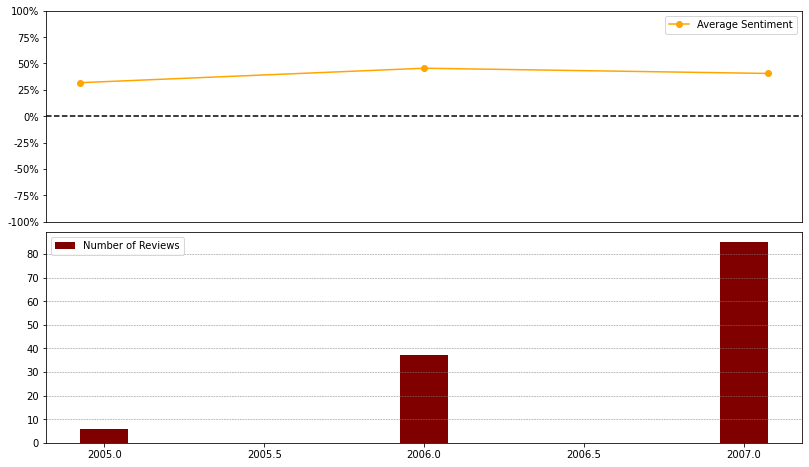

In [27]:
out = ipywidgets.widgets.Output()
plot_out =ipywidgets.widgets.Output()

dropdown_year = ipywidgets.widgets.Dropdown(options = createDropdown(sample['date'].dt.year.astype('Int64')), description = "Year: ")
dropdown_categories = ipywidgets.widgets.Dropdown(options = createDropdown(sample.product_type), description = "Product Type: ")
input_widgets = ipywidgets.widgets.HBox([dropdown_categories, dropdown_year], layout=Layout(width='60%',justify_content='space-between', margin='0 0 50px 0'))
tab = ipywidgets.widgets.Tab([out, plot_out])
tab.set_title(0, 'Summary Table')
tab.set_title(1, 'Trend Chart')
dashboard = ipywidgets.widgets.VBox([input_widgets, tab])

dropdown_categories.observe(DropdownTypeEventhandler, names='value')
dropdown_year.observe(DropdownYearEventhandler, names='value')
display(dashboard)

### References

* https://github.com/huggingface/naacl_transfer_learning_tutorial
* https://medium.com/swlh/transformer-fine-tuning-for-sentiment-analysis-c000da034bb5
